# IPR 2

### Welcome to Ameir and AJ's IPR. Here, I will walk through steps 5-7 of the ML Universal workflow. All code for this process is found below. 

### We opted to switch from merely classifying news articles from one binary category (pertinent to national security or not), to doing multiclass classification. Our aim was to build a model which can rival LTC Pedersen's model. We believe we may be able to outperform LTC Pedersen's model for two reasons. 
### 1. Our model was trained on labels from a newer LLM (Gemma 3, whereas LTC Pedersen's model was trained on Mistral labels). 
### 2. We employ roBERTa embeddings rather than BERT embeddings (which is what LTC Pedersen used). roBERTA (robustly optimizers bidirectional encoder representations for transformers agnostic) is an embedding space trained on about 10x more data than BERT. We believe this higher dimensionality (1024 vs 768) embedding space will allow for us to capture more nuance in language than BERT can. 


## Step 5. Beat the Baseline
#### Since we used a balanced dataset (where there is an equal amount of labels for each category), our lower baseline is simply 2788/41820 (6.67%). 
#### Our upper baseline is 80% - which is the predetermined acceptable accuracy to be deployed into production for ARCYBER. This number was detemrined by COL Beskow. Anything less than this would not be worth deploying.
#### Our next upper baseline is whatever LTC Pedersen's model is. Unfortunately, his model is still in development, and as of now, he has not evaluated on the same set which we are using for testing.
#### To build a model that can complete this task, we must first have a model that is trained on balanced data. I've found that by training on unbalanced data, our model will lean towards the majority class in each prediction. Due to the complexity of the data we are working with (1024 embedding for each article), that I can use a fairly complex model without fear of overfitting. I built a fairly complex model below which has over 9 million parameters. I trained it on the WIRE for faster training. Even with the A6000 Nvidia GPU, it took about 30 minutes to train only 15 epochs. 

## Step 6. Scale up

#### I attempted to overfit this model by making it overly complex. I found it very hard to build a model that overfits simply because I am training on roughly 30k articles. I would estimate that I would need a model about 5 times the size of mine to overfit. In order to train a model for this size, I would very likely crash the GPU I am using. I attempted to make the model more and more complex, but struggled to achieve a model that overfits

## Step 7. Regularize and Tune

#### I was able to build a model that generalizes well to new data by creating a complex model that was trained on balanced data. By training on balanced data, my model is more confident in its predictions. 

In [1]:
import pandas as pd
import json
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from sentence_transformers import SentenceTransformer, models

2025-05-06 14:51:32.788317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 14:51:32.929937: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 14:51:32.934265: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-06 14:51:32.934286: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
data = pd.read_json('cc_data_and_labels.jsonl', lines=True)
data.head()

,text,id,title,description,date,meaning,category
0,Cyberbit Ltd.\nCyberbit wird von unabhängigem ...,6aba0f3762b987b997afc8d21b2708cf92d56e54f08710...,Cyberbit wird von unabhängigem Forschungsunter...,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,2023-12-12 16:26:22+00:00,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,technology
1,Cyberbit Ltd.\nCyberbit wird von unabhängigem ...,9f948c4b5229a4930ee7a6583e20cfeae10647ed6dfce2...,Cyberbit wird von unabhängigem Forschungsunter...,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,2023-12-12 16:26:14+00:00,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,technology
2,WASHINGTON (AP) — President Joe Biden describe...,203852ceae3fd1d12b47dc1f581d086a964a064dad39bf...,Biden calls Australia ‘an anchor to peace and ...,WASHINGTON (AP) — President Joe Biden describe...,2023-10-27 22:26:07+00:00,WASHINGTON (AP) — President Joe Biden describe...,politics
3,"Un’amicizia sociale, la definirebbe papa Franc...",5248d1ed5a58da7f27266c7ef14c7f07966dee885dab8a...,"Modica, carabinieri e casa Don Puglisi per cre...",A Modica l'amicizia sociale tra l'Arma dei car...,2023-12-12 16:17:01+00:00,A Modica l'amicizia sociale tra l'Arma dei car...,culture
4,"New Delhi, Finance Minister Nirmala Sitharaman...",dc80e51187756385c77ececd68fd16a45b4ff1b212dd5f...,Finance Minister Nirmala Sitharaman meets head...,This is the probably last full review meeting ...,2023-12-30 15:08:18+00:00,This is the probably last full review meeting ...,economy


In [3]:
#check how much of each category is present
data['category'].value_counts()

category
politics             91336
business             73302
entertainment        55078
cyber                52230
sports               49503
crime                42988
uncategorized        37059
technology           34477
culture              26768
economy              18561
health               13905
advertising           9695
weather               8593
national security     7144
science               2864
Name: count, dtype: int64

### This is a very imbalanced dataset. After doing some research into balancing datasets, I think an appropriate approach is to create a balanced dataframe with 2864 observations of each label. By training on this data, it will result in our model overpredicting the dominant classes.

In [4]:
#Drop duplicate data. 
data = data.drop_duplicates(subset = ['id', 'title'])
data = data.dropna(subset = ['category'])

In [5]:
#Drop articles that were parsed into the df incorrectly (ChatGPT Helped us here)
data = data[~data['text'].astype(str).str.startswith('{')]
print(f' we have {data.shape[0]} unique records to work with after filtering')

 we have 493925 unique records to work with after filtering


In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE', device='cuda')

# Create embeddings for your text data
texts = data['meaning'].astype(str).tolist()
embeddings = model.encode(texts, show_progress_bar=True, batch_size=64)

# Add embeddings to DataFrame
data['embedding'] = list(embeddings)

Batches: 100%|██████████| 8180/8180 [17:14<00:00,  7.91it/s] 


### We now need to map each category to a number for training. Originally COL Beskow wanted business/economy & health/sciecne separate. After seeing how subjective these labels can be, we settled to allow these to be classified as the same category number

In [10]:
#Map categories to numbers. ChatGPT helped me with this code. 
category_map = {
    'politics': 0,
    'business': 1,
    'entertainment': 2,
    'cyber': 3,
    'sports': 4,
    'crime': 5,
    'uncategorized': 6,
    'technology': 7,
    'culture': 8,
    'health': 9,
    'advertising': 10,
    'weather': 11,
    'national security': 12,
    'economy':1,
    'science':9
    
}


# Create numeric category column
data['category_num'] = data['category'].map(category_map)
data = data[data['category_num'] != 6].reset_index(drop=True)
# Drop rows with unmapped categories
data = data[~data['category_num'].isna()].reset_index(drop=True)

data['category_num'].value_counts()

category_num
1.0     91863
0.0     91336
2.0     55078
3.0     52230
4.0     49503
5.0     42988
7.0     34477
8.0     26768
9.0     16769
10.0     9695
11.0     8593
12.0     7144
Name: count, dtype: int64

In [11]:
from sklearn.utils import resample

# Group by category_num
# Determine the minimum class size for undersampling
min_size = data['category_num'].value_counts().min()

# Create a balanced dataset by undersampling each class
balanced_dfs = []

for label in data['category_num'].unique():
    df_label = data[data['category_num'] == label]
    
    # Guard against sampling more than available
    if len(df_label) < min_size:
        raise ValueError(f"Not enough samples in class {label} to sample {min_size} rows.")
    
    df_sampled = resample(
        df_label,
        replace=False,              # No replacement — undersampling
        n_samples=min_size,
        random_state=42
    )
    balanced_dfs.append(df_sampled)

# Combine, shuffle, and reset index
balanced_data = pd.concat(balanced_dfs).sample(frac=1, random_state=18).reset_index(drop=True)

# Output the new distribution and shape
print("New class distribution:\n", balanced_data['category_num'].value_counts())
print("Total samples:", balanced_data.shape[0])


New class distribution:
 category_num
7.0     7144
11.0    7144
9.0     7144
8.0     7144
1.0     7144
5.0     7144
10.0    7144
12.0    7144
0.0     7144
3.0     7144
4.0     7144
2.0     7144
Name: count, dtype: int64
Total samples: 85728


In [12]:
# Recreate X and y so we can use the indices
#ChatGPT Helped me split the data
from sklearn.model_selection import train_test_split

X = np.stack(balanced_data['embedding'].values)
y = balanced_data['category_num'].values

# Get original indices before the split
original_indices = balanced_data.index.values

# Perform the split using the indices
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X, y, original_indices, stratify=y, test_size=0.3, random_state=24)

X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, stratify=y_temp, test_size=0.5, random_state=42)

# Use idx_test to grab the rows from the original balanced_data
test = balanced_data.loc[idx_test].reset_index(drop=True)


In [13]:
print(X_train.shape)  # Should be (num_samples, 1024)
print(X_val.shape) 
print(X_test.shape) 

#X_temp is val+test. 
print(X_temp.shape) 
print(y_train.shape)

(60009, 768)
(12859, 768)
(12860, 768)
(25719, 768)
(60009,)


In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=14)
y_val = to_categorical(y_val, num_classes=14)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models, optimizers
from tensorflow.keras.activations import swish

# Model architecture
inputs = layers.Input(shape=(768,), name='input_layer')

# Initial projection
x = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.4)(x)

# Residual Block 1
res = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
res = layers.LayerNormalization()(res)
res = layers.Dropout(0.4)(res)
x = layers.Add()([x, res])  # Residual connection

# Deep residual block stack
for _ in range(4):
    dense = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
    dense = layers.LayerNormalization()(dense)
    dense = layers.Dropout(0.3)(dense)
    x = layers.Add()([x, dense])

# Wide dense layer block
wide = layers.Concatenate()([
    layers.Dense(256, activation='relu')(x),
    layers.Dense(256, activation='sigmoid')(x),
    layers.Dense(256, activation='tanh')(x)
])
x = layers.Concatenate()([x, wide])  # Final wide layer shape = 1024 + 3*256 = 1792

# Final MLP layers
x = layers.Dense(512, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)

# Output layer for 14 classes
outputs = layers.Dense(14, activation='softmax')(x)

# Build and compile the model
model = models.Model(inputs=inputs, outputs=outputs, name="ultra_dense_classifier")
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()




Model: "ultra_dense_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 768)]        0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 1024)         787456      ['input_layer[0][0]']            
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 1024)        2048        ['dense_14[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 dropout_10 (Dropout)           (None, 1024)         0           ['layer_norm

In [19]:
#ChatGPT helped me integrate callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',            # Watch validation loss
    patience=6,                    # Stop after 6 epochs without improvement
    restore_best_weights=True,    # Roll back to the best weights
    verbose=1                      # Print when early stopping happens
)

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs = 40,
    batch_size=64,
    callbacks=[early_stopping],   # 👈 Add this line
    verbose=1
)



Epoch 1/40
938/938 [==============================] - 63s 63ms/step - loss: 2.4795 - accuracy: 0.4401 - val_loss: 1.8498 - val_accuracy: 0.6081
Epoch 2/40
938/938 [==============================] - 59s 63ms/step - loss: 1.9789 - accuracy: 0.5688 - val_loss: 1.7941 - val_accuracy: 0.6151
Epoch 3/40
938/938 [==============================] - 59s 63ms/step - loss: 1.8888 - accuracy: 0.5919 - val_loss: 1.7509 - val_accuracy: 0.6267
Epoch 4/40
938/938 [==============================] - 59s 62ms/step - loss: 1.8344 - accuracy: 0.6017 - val_loss: 1.7198 - val_accuracy: 0.6320
Epoch 5/40
938/938 [==============================] - 59s 62ms/step - loss: 1.7897 - accuracy: 0.6100 - val_loss: 1.6958 - val_accuracy: 0.6366
Epoch 6/40
938/938 [==============================] - 59s 62ms/step - loss: 1.7485 - accuracy: 0.6169 - val_loss: 1.6754 - val_accuracy: 0.6347
Epoch 7/40
938/938 [==============================] - 59s 62ms/step - loss: 1.7128 - accuracy: 0.6208 - val_loss: 1.6484 - val_accuracy:

In [20]:
y_pred_probs = model.predict(X_test)  # This gives probabilities


402/402 [==============================] - 7s 16ms/step


In [21]:
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class labels

In [22]:
# ChatGPT helped me predict on the whole test set.
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.6387


In [23]:
# Get predicted probabilities and predicted class indices. ChatGPT helped here.
y_full_probs = model.predict(np.stack(balanced_data['embedding'].values))
y_full_pred = np.argmax(y_full_probs, axis=1)

# Reverse the category map to map indices back to category names
rev_category_map = {v: k for k, v in category_map.items()}

# Add predictions to the original DataFrame
balanced_data['preds'] = y_full_pred
balanced_data['predicted_category'] = pd.Series(y_full_pred, index=balanced_data.index).map(rev_category_map)


2679/2679 [==============================] - 42s 16ms/step


In [24]:
balanced_data.head()

,text,id,title,description,date,meaning,category,embedding,category_num,preds,predicted_category
0,Gestisci più account e app e passa facilmente ...,712c704819e6f4f281cc0b299f3e46162b8b10ee1acfc6...,"App desktop per Mac, Windows (PC), Linux",Scarica l'app desktop di OnTheClock su WebCata...,2023-12-08 18:35:45+00:00,Scarica l'app desktop di OnTheClock su WebCata...,technology,"[-0.021106986, -0.037698735, 0.01254585, -0.05...",7.0,7,technology
1,This site uses cookies. By continuing to use t...,f35af72922a871b1eccce1ce6b8ed747a79793df9bef26...,Straight Line of the Day: Do You Have Climate ...,None,2024-09-15 23:25:45+00:00,None,weather,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",11.0,2,entertainment
2,Kolejki na NFZ do pulmonologa w Sosnowcu - sta...,cb53c1b968ba85bc1fe60af1ffe8cc4a773ef65627c817...,Ile trzeba czekać na wizytę do pulmonologa w S...,Zwykle na wizytę u specjalisty trzeba sporo cz...,2023-02-17 00:57:03+00:00,Zwykle na wizytę u specjalisty trzeba sporo cz...,health,"[-0.040934026, -0.024714153, 0.03381788, 0.061...",9.0,9,science
3,Gerade befinden wir uns in der (hoffentlich) l...,8bd1dc2b717e299cf3c855cd94f1861779118c6d834c79...,Gyrossuppe: eine Schüssel Griechenland,Gyrossuppe ist schnell zubereitet und acht die...,2024-04-24 09:44:08+00:00,Gyrossuppe ist schnell zubereitet und acht die...,culture,"[0.013790288, -0.055860125, -0.0046448754, 0.0...",8.0,8,culture
4,Für die Aktie Acer Therapeutics aus dem Segmen...,4a28dcb297ee56fb88199831ea3df712ccd40c572f13fb...,"Acer Therapeutics Aktie: Einfach nur Wahnsinn,...","Acer Therapeutics Aktie: Einfach nur Wahnsinn,...",2023-02-19 20:36:45+00:00,"Acer Therapeutics Aktie: Einfach nur Wahnsinn,...",business,"[-0.06650841, -0.036377445, -0.052908115, 0.03...",1.0,1,economy


In [25]:
balanced_data['predicted_category'].value_counts()

predicted_category
entertainment        23449
national security     6196
sports                6045
weather               5988
crime                 5875
technology            5856
culture               5681
science               5586
economy               5344
cyber                 5334
politics              5266
advertising           5108
Name: count, dtype: int64

In [117]:
#ChatGPT taught me how to save my model. 
model.save("model4")


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


### Now we can go through and hand label some of these to add on top of our accuracy in places we thought our model labeled better than the LLM. 

In [26]:
#ChatGPT helped split into unbalanced. 
wrongpreds = balanced_data[balanced_data['category_num'] != balanced_data['preds']]
sample = wrongpreds.sample(n=100, random_state=42)
sample[0:50]

,text,id,title,description,date,meaning,category,embedding,category_num,preds,predicted_category
4784,Associated Press\nThe U.S. Secret Service is i...,4d46bb9077a476edd4537aca279ee7988f326f59453fbc...,The Secret Service is investigating how a gunm...,None,2024-07-14 05:56:42+00:00,None,national security,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",12.0,2,entertainment
8255,A Somogy Vármegyei Rendőr-főkapitányság bűnmeg...,47c3ea44465863fef51cf2198f3509800eb57ffd0b2016...,Somogyi gyereket már nem csapnak be internetes...,A Mátrix Projekt keretében egész héten járták ...,2024-02-09 10:45:45+00:00,A Mátrix Projekt keretében egész héten járták ...,crime,"[0.046820857, -0.058540523, 0.03335572, -0.024...",5.0,3,cyber
10031,OrbisResearch.com offers a download for the st...,cbe90acaf3af44eadbc0b859293f333fa7988f362e0776...,WordPress Web Hosting Services Market 2023 [SW...,None,2024-05-02 06:44:12+00:00,None,business,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",1.0,2,entertainment
85537,(Editor's note: Photos from the Honor Flight m...,8ac822a28a3eb090a2d4d5a66a285d799281b83a78ca7c...,"Amberg's ""bucket list"" D.C. trip achieved",None,2024-06-27 00:02:50+00:00,None,culture,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",8.0,2,entertainment
68122,Technology Safeguarding trust: Third party ser...,94945bca92427c9eca1e3dc62fb7f3a7f0f2a1c3024d84...,Safeguarding trust: Third party service provid...,Businesses embracing third-party services must...,2024-01-15 06:49:10+00:00,Businesses embracing third-party services must...,technology,"[-0.005287023, -0.052650243, 0.055620626, -0.0...",7.0,3,cyber
62527,"Police want a ""refocus"" of their work, accordi...",5fccd2fa573bc8dfb6185fab560a88ee1d71f856ecf42d...,"Police may step back from family harm, mental ...",None,2024-02-01 07:58:53+00:00,None,crime,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",5.0,2,entertainment
3365,دمشق-سانا\nناقش صناعيو الكونسروة ورب البندورة ...,7607aee86b05bf7528d1456d960387586fda35f65b018f...,تأمين مدخلات الإنتاج… محور مناقشات صناعيي الكو...,None,2024-08-20 16:38:06+00:00,None,business,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",1.0,2,entertainment
50495,Update your web browser!\nOh no! It looks like...,b93f051dced2f179bea45747b188b5aa43bfe4dbabe3c2...,Crunchyroll logo,None,2024-05-13 14:06:57+00:00,None,advertising,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",10.0,2,entertainment
33298,Reporteros Sin Fronteras (RSF) honró este mart...,694b192366d9c439da8844e1be3063d02d44cbbe1957d4...,Reporteros Sin Fronteras premia a Wael al-Dahdouh,None,2024-12-06 22:07:35+00:00,None,culture,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",8.0,2,entertainment
43624,Os cookies nos ajudam a administrar este site....,eb0f5e9c79dddcb9dd08a392000f184d0397794fc41aec...,Carros elétricos: queda nas vendas expõe os de...,None,2024-06-06 16:46:17+00:00,None,advertising,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",10.0,2,entertainment


In [28]:
sample[50:100]

,text,id,title,description,date,meaning,category,embedding,category_num,preds,predicted_category
2312,"Mientras lees estas líneas, una empresa españo...",79175ba025d02167164bf9c3aa05fb963fef9125c737e9...,Una sonda espacial hecha en España visitará po...,"Sener, empresa de referencia en ingeniería y t...",2024-01-26 18:04:22+00:00,"Sener, empresa de referencia en ingeniería y t...",technology,"[-0.052724283, -0.030937197, 0.01617827, 0.029...",7.0,9,science
40195,COLUMN Drones: voor al uw spectacu­lai­re beel...,d66c5f764630e77b6fc1bce46c326cc1dd3d0dc4c60d6c...,Liefdeslessen op Da Vinci College in Roosendaa...,Wat is verliefdheid of een leuke date? Krijg j...,2023-02-13 20:17:46+00:00,Wat is verliefdheid of een leuke date? Krijg j...,culture,"[0.0069138273, -0.046284463, -0.029917566, -0....",8.0,2,entertainment
64339,"*Prices, promotions and availability may vary ...",a6d6266ed354d47b85ce887ca8f50b0e9c45c9bda0f79f...,LG ThinQ : The new way of living,None,2024-12-04 21:00:44+00:00,None,advertising,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",10.0,2,entertainment
35666,"In this image provided by the U.S. Navy, the a...",829f7224a1a36eb01a90305f2158a7c992033fd5ba18f5...,US warns Houthis to cease attacks on Red Sea v...,The United States and 12 allies has given what...,2024-01-04 00:08:20+00:00,The United States and 12 allies has given what...,politics,"[-0.03039022, -0.018460125, -0.02228222, 0.024...",0.0,12,national security
56427,"TOKYO, Dec. 26, 2023 /PRNewswire/ -- Unifly, a...",60def5462c27bc8c9036b9e132fd5238e88f1f4c94de36...,"Terra Drone's Group Company, Unifly, Successfu...",None,2023-12-27 01:26:26+00:00,None,technology,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",7.0,2,entertainment
64081,Hannover (dpa/lni) –\nNiedersachsens Kultusmin...,046192d6279d0d58500797964b52423821622900fe3a76...,Kultusministerin gegen Reform der Bundesjugend...,None,2024-06-28 06:28:20+00:00,None,culture,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",8.0,2,entertainment
36963,"(Teleborsa) - ""L'e per l'ecosistema dei pagame...",48f75af00ebcaa8eb2d56678a8947d777a9e2ecb9d9d98...,Bankitalia: rischi per settore finanziario da ...,"""L'importanza cruciale della tecnologia per l'...",2024-03-13 16:31:20+00:00,"""L'importanza cruciale della tecnologia per l'...",economy,"[-0.01251606, -0.022652572, 0.014630637, -0.05...",1.0,7,technology
49278,None,b2b41c2d30c25058a9ee9fe428a4ed37870cac925423fc...,Trung tâm Ứng dụng tiến bộ KH&CN TP. Cần Thơ: ...,None,2023-02-13 16:11:22+00:00,None,science,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",9.0,2,entertainment
65883,"Douglassville, PA Real Estate Agents and Realt...",53bb62267073e321e20390f995743e24425d80d167171f...,Find Real Estate Agents & Realtors in Douglass...,None,2024-04-12 11:16:44+00:00,None,business,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",1.0,2,entertainment
71027,2024-03-11 11:50:03 - المصدر: الاقتصاد نيوز\nأ...,a6506e1991eb9314d36750f25cc9afcdc19ef11ba19a43...,خلال كانون الثاني الماضي ارتفاع مستويات التضخم...,None,2024-03-11 09:04:36+00:00,None,economy,"[-0.05239778, -0.028592076, -0.07679257, 0.009...",1.0,2,entertainment


## Lets create some visualizations showcasing our model's performance

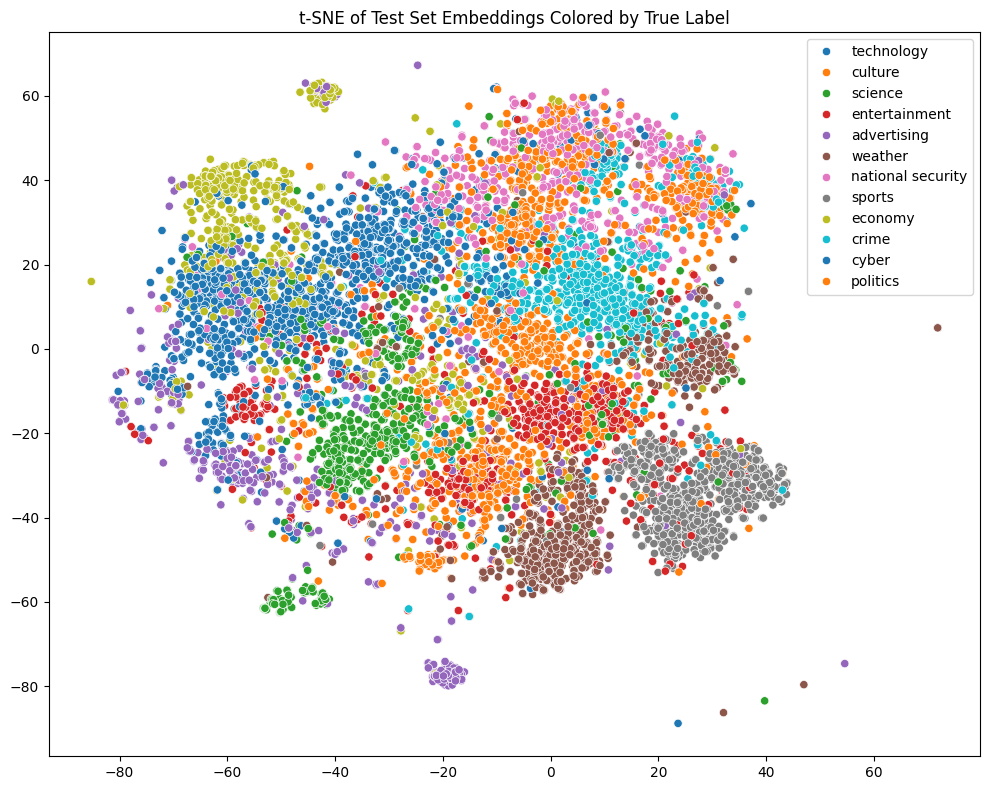

In [29]:
#ChatGPT Helped create the visualizations. 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# (1) Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_test)

# (2) Convert y_test numbers back to labels
inv_category_map = {v: k for k, v in category_map.items()}  # Reverse mapping
y_test_labels = [inv_category_map[num] for num in y_test]

# (3) Plot t-SNE with fig, ax
fig, ax = plt.subplots(figsize=(10, 8))  # ✅ create fig, ax

sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_test_labels, palette='tab10', legend='full', ax=ax)
ax.set_title("t-SNE of Test Set Embeddings Colored by True Label")

plt.tight_layout()  # ✅ call this before save

# (4) Save the figure
fig.savefig('tsne.png', dpi=1600, bbox_inches='tight')  # 🔥 dpi=600 is plenty
plt.show()




In [30]:
#ChatGPT Helped us create this code. 

import numpy as np
from sklearn.metrics import confusion_matrix

category_labels = balanced_data['category'].astype(str).unique()


cm = confusion_matrix(y_test, y_pred)
np.fill_diagonal(cm, 0)
confused_pairs = np.unravel_index(np.argsort(cm, axis=None)[-5:], cm.shape)

for i in range(5):
    print(f"Confused: {category_labels[confused_pairs[0][i]]} as {category_labels[confused_pairs[1][i]]}")


Confused: economy as health
Confused: business as health
Confused: advertising as health
Confused: cyber as health
Confused: national security as health


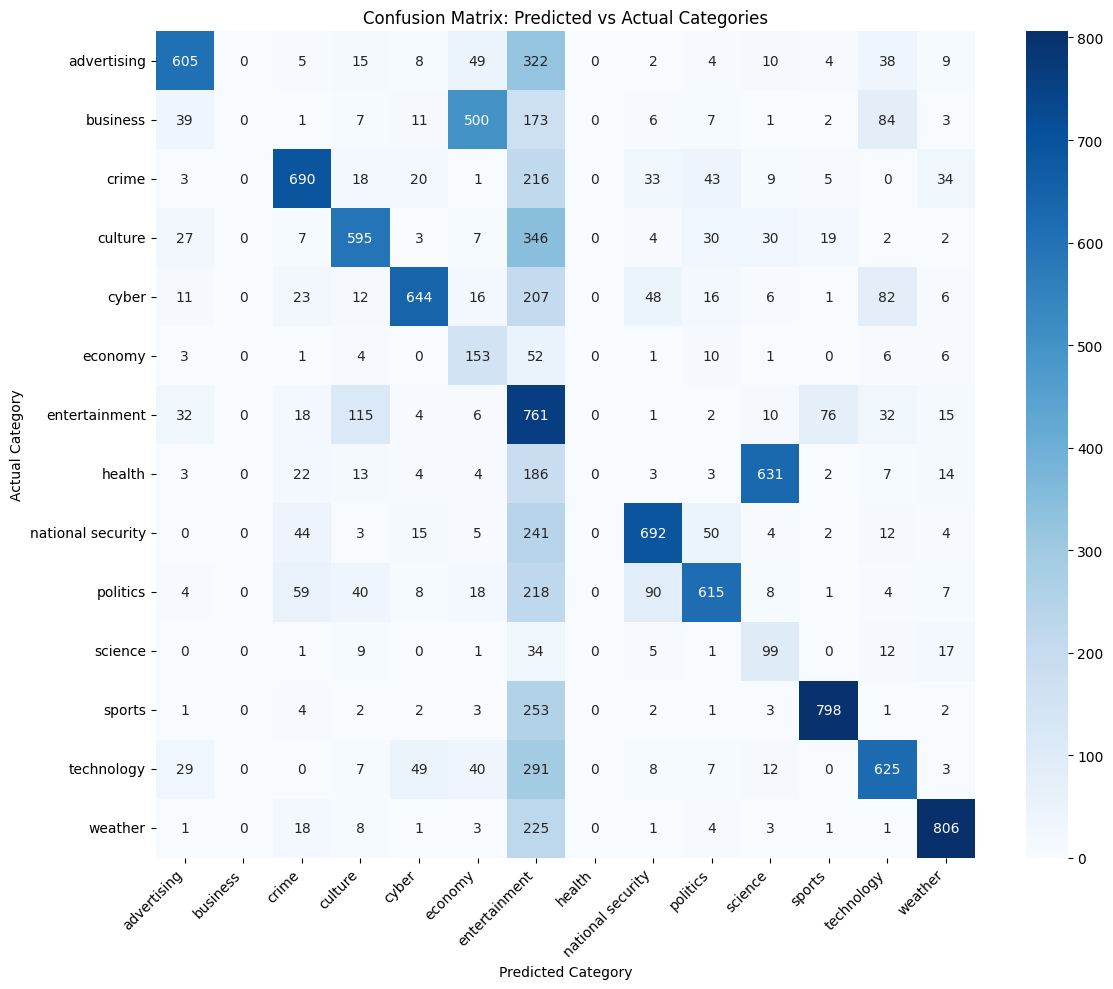

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# (1) Get the true labels
y_true_labels = test['category'].values

# (2) Reverse mapping for category numbers
inv_category_map = {v: k for k, v in category_map.items()}

# Map predicted numbers back to labels
y_pred_labels = [inv_category_map[num] for num in y_pred]

# (3) Create confusion matrix
labels_sorted = sorted(balanced_data['category'].unique())
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels_sorted)

# (4) Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # <-- use fig, ax structure
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_sorted,
            yticklabels=labels_sorted,
            ax=ax)

ax.set_xlabel('Predicted Category')
ax.set_ylabel('Actual Category')
ax.set_title('Confusion Matrix: Predicted vs Actual Categories')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()  # <-- Call this first

# 🔵 Now save the figure
fig.savefig('confusion_matrix.png', dpi=1600, bbox_inches='tight')

plt.show()  # <-- Then show it




/tmp/ipykernel_339/2954112316.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=categories, y=accuracies, palette=bar_colors, edgecolor="black")
/tmp/ipykernel_339/2954112316.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)


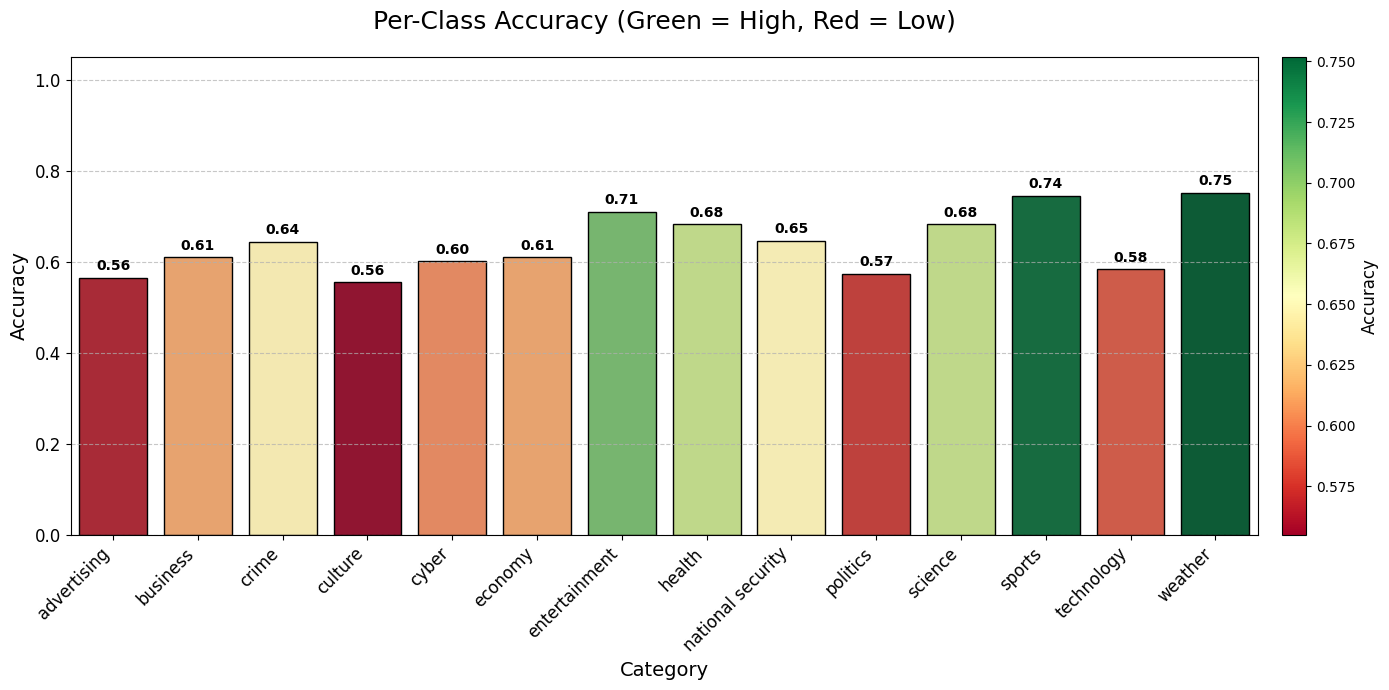

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Calculate per-class accuracy
accuracies = []
categories = sorted(balanced_data['category'].unique())

for category in categories:
    idx = y_test == category_map[category]
    acc = (np.array(y_pred)[idx] == y_test[idx]).mean()
    accuracies.append(acc)

# Set up figure
fig, ax = plt.subplots(figsize=(14, 7))

# Create a green-to-red color map
norm = mcolors.Normalize(vmin=min(accuracies), vmax=max(accuracies))
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# Color bars based on accuracy
bar_colors = [sm.to_rgba(acc) for acc in accuracies]

# Create barplot
bars = sns.barplot(x=categories, y=accuracies, palette=bar_colors, edgecolor="black")

# Annotate bars
for bar, acc in zip(bars.patches, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{acc:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xlabel('Category', fontsize=14)
ax.set_title('Per-Class Accuracy (Green = High, Red = Low)', fontsize=18, pad=20)
ax.set_ylim(0, 1.05)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add colorbar for reference
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Accuracy', fontsize=12)

plt.tight_layout()
plt.show()


